In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, confusion_matrix, precision_score, pairwise
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import math

In [129]:
# importing the features normalised and dropping all the non relevant columns to have a clean start
df = pd.read_csv("../data/processed/ISIC_2017_norm_features.csv")
df = df.drop(["seborrheic_keratosis", "Perimeter", "Area", "image_id", "Red", "Green", "Blue"], axis=1)


df.head()
#Note: for sex, 1 is female, 0 is male

,melanoma,Norm_Compactness,Norm_Asymmetry,Norm_Average Color,Norm_Age,Sex
0,0.0,0.434213,0.565848,0.512858,0.647059,1
1,0.0,0.079822,0.714482,0.513188,0.352941,1
2,1.0,0.312995,0.818309,0.657999,0.705882,1
3,0.0,0.346936,0.747794,0.628721,0.352941,0
4,1.0,0.381283,0.671515,0.458960,0.941176,0


In [130]:
#copying the dataframe. it should be with .copy() but it works like this too
df2 = df.copy()


# Some noisy features
noise = np.random.RandomState(42).uniform(0, 0.1, size=(df2.shape[0], 20))

# Add the noisy data to the informative features
# this is not something that makes sense to me. we add the noise to then ignore it in the next cell
X = np.hstack((df2[['Norm_Compactness', 'Norm_Asymmetry', "Norm_Average Color"]], noise))
y = df2['melanoma'].astype("int32")


# Split dataset to select feature and evaluate the classifier
# the splitting is done by splitting the data into data to be used for training and validation (development of the model --> dev), and data to be used for testing. 
X_dev, _, y_dev, _ = train_test_split(
        X, y, stratify=y)

# the development data is split into training and validation.
X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev)




#OverSampling to compensate for imbalanced dataset
oversample = RandomOverSampler(sampling_strategy = 0.75)
X_over, y_over = oversample.fit_resample(X,y)


#Splitting oversampled data 
# Split dataset to select feature and evaluate the classifier
# the splitting is done by splitting the data into data to be used for training and validation (development of the model --> dev), and data to be used for testing. 
X_dev, _, y_dev, _ = train_test_split(
        X_over, y_over, stratify=y_over)

# the development data is split into training and validation.
X_train_over, X_val_over, y_train_over, y_val_over = train_test_split(
        X_dev, y_dev, stratify=y_dev)




In [134]:
# Train a classifier
X_train_over = X_train_over[:,0:3] # Take only wanted features
X_val = X_val[:, 0:3] # Take only wanted features
X_val_over = X_val_over[:,0:3]
roc_dict = {}
knn_list = [None]

neigh = int(math.sqrt(len(X_train)))
neigh
# the range is to the neigh, as some sources suggest to use the square root of the number of datapoints, and it does seem as a fair estimation to decrease error
for i in range(1, neigh+1):
    #train the model with different values of the neighbors
    knn1 = KNeighborsClassifier(n_neighbors=i) 
    knn1trained = knn1.fit(X_train_over, y_train_over)
    
    #Select the same features as before
    
    y_val_knn1 = knn1trained.predict_proba(X_val)
    print(roc_auc_score(y_val_over,knn1trained.predict(X_val_over)),roc_auc_score(y_val,knn1trained.predict(X_val)))
    
    #adding the roc_score value to the dictionary to assess which is the best
    # can be calculated with another calculation, but it would be time consuming to do both to show they are identical
    fpr, tpr, threshold = roc_curve(y_val, y_val_knn1[:,1])
    roc_test = auc(fpr,tpr)
    roc_dict[i] = roc_test
    knn_list.append(knn1trained)


# getting all the values with the highest accuracy score
max_keys = [key for key, value in roc_dict.items() if value == max(roc_dict.values())]

# we use the biggest of the neighbors values as the neighbor to use for the classification, as a lower value is not recomended 
print(roc_dict[max_keys[-1]])

#best trained knn algorithm
final_knn_trained = knn_list[max_keys[-1]]
print(roc_dict)

0.8366597465817166 0.9096018735362996
0.7378838857470112 0.7996487119437938
0.7039587658386426 0.7967213114754099
0.6674493521368745 0.7058548009367681
0.6739494595175031 0.6891100702576113
0.6532536330445987 0.6510538641686184
0.6761257069224712 0.6984777517564402
0.6428663469110173 0.6230679156908665
0.6499248335600257 0.6298594847775175
0.6406686233803421 0.6154566744730678
0.6411768916887394 0.6485948477751757
0.6450425943159854 0.6505854800936768
0.6564750519006372 0.6688524590163935
0.6423079676426373 0.6412177985948478
0.6324575846517287 0.6413348946135831
0.6324933781945739 0.6389929742388759
0.6291860548357077 0.6725995316159251
0.6292003722528456 0.6577283372365339
0.6324504259431598 0.6441451990632319
0.6319278402176248 0.6385245901639344
0.636280335027561 0.6451990632318501
0.6324790607774357 0.6297423887587822
0.6286276755673276 0.6314988290398127
0.6144605913093278 0.6297423887587822
0.6160856181544849 0.6539812646370023
0.6122843439043597 0.6505854800936768
0.60461736702

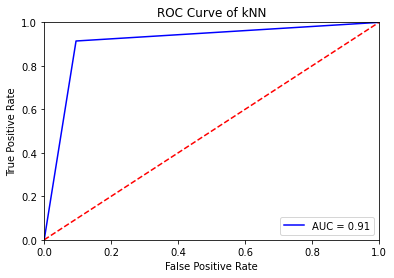

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 

In [135]:
y_scores = final_knn_trained.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()
print(y_scores)

In [138]:
tn, fp, fn, tp = (confusion_matrix(y_val,final_knn_trained.predict(X_val))).ravel()
print(tn,fp,fn,tp)


276 29 6 64


In [139]:
final_knn_trained.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [141]:
# Train a classifier
X_train_over = X_train_over[:,0:2] # Take only wanted features
roc_dict = {}


# the range is to the neigh, as some sources suggest to use the square root of the number of datapoints, and it does seem as a fair estimation to decrease error


gnb = GaussianNB() 
gnb = gnb.fit(X_train_over, y_train_over)
    
#Select the same features as before
X_val = X_val[:, 0:2]
y_val_gnb = gnb.predict_proba(X_val)
print(roc_auc_score(y_val,gnb.predict(X_val)))

#adding the roc_score value to the dictionary to assess which is the best
# can be calculated with another calculation, but it would be time consuming to do both to show they are identical
fpr, tpr, threshold = roc_curve(y_val, y_val_gnb[:,1])
roc_test = auc(fpr,tpr)
roc_dict[i] = roc_test



# getting all the values with the highest accuracy score
max_keys = [key for key, value in roc_dict.items() if value == max(roc_dict.values())]

# we use the biggest of the neighbors values as the neighbor to use for the classification, as a lower value is not recomended 
print(roc_dict[max_keys[-1]])

#best trained knn algorithm
final_knn_trained = knn_list[max_keys[-1]]
print(roc_dict)

IndentationError: unexpected indent (<ipython-input-141-aba9a2797253>, line 13)